In [2]:
cd ..

/Users/lisawink/Documents/freiburg


In [213]:
import pandas as pd
import geopandas as gpd
import calc_params
from tqdm import tqdm
import pandas as pd
from tqdm import tqdm
import numpy as np
from scipy.stats import pearsonr, spearmanr
from datetime import datetime
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from importlib import reload

In [41]:
reload(calc_params)

<module 'calc_params' from '/Users/lisawink/Documents/freiburg/calc_params.py'>

In [136]:
def calc_diurnal(hid, radius=200, season='year'):

    temp =  pd.read_csv('/Users/lisawink/Documents/paper1/data/gap_filled_data_ta_rh.csv')
    temp['datetime_UTC']=pd.to_datetime(temp['datetime_UTC'])
    temp = temp[temp['variable']=='Ta_deg_C']
    temp = temp[temp['datetime_UTC'].dt.date.isin(hid['datetime_UTC'].dt.date)]
    temp['datetime_UTC'] = temp['datetime_UTC'].astype(str)
    temp = temp.pivot(index='station_id', columns='datetime_UTC', values='value')

    params = gpd.read_parquet(f'/Users/lisawink/Documents/paper1/data/processed_data/processed_station_params_{radius}.parquet')
    params = params.set_index('station_id')
    to_remove = ['station_no','station_name','station_long_name','station_type','station_lat','station_lon','station_elevation','mounting_structure','sky_view_factor','dominant_land_use','local_climate_zone','urban_atlas_class','urban_atlas_code','geometry','SVF']
    params = params.drop(to_remove, axis=1)
    vars = params.columns

    vars = ['BuAre_sum', 'BuVol_3D_sum', 'BuSA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','BuOri_mean', 'BuSqC_wmean','BuFra_3D_wmean', 'StrClo400_median']

    for var in vars:
        params_v = params[[var]]

        stats_dict = {}

        for time in temp.columns:
            params_t = params_v.merge(temp[time], left_on='station_id', right_on='station_id',how='inner')
            stats = calc_params.calculate_statistics(params_t, time)
            stats.index = stats['Parameter']
            stats['Time'] = time
            stats_dict[time] = stats
        pd.concat(stats_dict).to_csv(f'/Users/lisawink/Documents/paper1/data/processed_data/diurnal/{season,var,radius}.csv')   

In [191]:
def plot_diurnal(season='year', radius=200):
    # List of variables to plot
    vars_to_plot = ['BuAre_sum', 'BuVol_3D_sum', 'BuSA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','BuOri_mean', 'BuSqC_wmean','BuFra_3D_wmean', 'StrClo400_median']
    i=200

    # Create a 3x3 subplot figure
    fig = make_subplots(rows=4, cols=3, subplot_titles=vars_to_plot)

    # Loop through variables and plot them in subplots
    for idx, var in enumerate(vars_to_plot):
        row = idx // 3 + 1  # Determine row index (1-based)
        col = idx % 3 + 1    # Determine column index (1-based)
        
        # Load and process data
        stats_dict = pd.read_csv(f'/Users/lisawink/Documents/paper1/data/processed_data/diurnal/{season,var,i}.csv') 
        stats_dict['Time'] = pd.to_datetime(stats_dict['Time'])  # Ensure 'Time' is datetime
        stats_dict['Hour'] = stats_dict['Time'].dt.hour  # Extract hour

        #colour by season
        if season == 'year':
            stats_dict['Season'] = stats_dict['Time'].dt.month
            stats_dict['Season'] = stats_dict['Season'].replace({1:'winter',2:'winter',3:'spring',4:'spring',5:'spring',6:'summer',7:'summer',8:'summer',9:'autumn',10:'autumn',11:'autumn',12:'winter'})
        else:
            stats_dict['Season'] = season

        # Create scatter plot for each season
        for season_name, color in {'winter':'blue', 'spring':'green', 'summer':'orange', 'autumn':'purple'}.items():
            season_data = stats_dict[stats_dict['Season'] == season_name]
            scatter = go.Scatter(x=season_data['Hour'], y=season_data['Spearman Correlation'], 
                                mode='markers', name=season_name, marker=dict(color=color), opacity=0.5, showlegend=(idx == 0))
            # Add to subplot
            fig.add_trace(scatter, row=row, col=col)

        # Update x-axis and y-axis labels for each subplot
        fig.update_xaxes(title_text="Hour of Day", row=row, col=col)
        fig.update_yaxes(title_text="Spearman Correlation", row=row, col=col)


    # Update layout
    fig.update_layout(title="Diurnal Spearman Correlation Plots", height=900, width=900)

    # Show figure
    fig.show()

In [234]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_diurnal_pub(season='year', radius=200):
    # List of variables to plot
    vars_to_plot = ['BuAre_sum', 'BuVol_3D_sum', 'BuSA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','BuOri_mean', 'BuSqC_wmean','BuFra_3D_wmean', 'StrClo400_median']
    i = 200

    # Create a 4x3 subplot figure
    fig, axes = plt.subplots(4, 3, figsize=(15, 15))
    axes = axes.flatten()

    # Loop through variables and plot them in subplots
    for idx, var in enumerate(vars_to_plot):
        ax = axes[idx]
        
        # Load and process data
        stats_dict = pd.read_csv(f'/Users/lisawink/Documents/paper1/data/processed_data/diurnal/{season,var,i}.csv') 
        stats_dict['Time'] = pd.to_datetime(stats_dict['Time'])  # Ensure 'Time' is datetime
        stats_dict['Hour'] = stats_dict['Time'].dt.hour  # Extract hour

        # Colour by season
        if season == 'year':
            stats_dict['Season'] = stats_dict['Time'].dt.month
            stats_dict['Season'] = stats_dict['Season'].replace({1:'winter',2:'winter',3:'spring',4:'spring',5:'spring',6:'summer',7:'summer',8:'summer',9:'autumn',10:'autumn',11:'autumn',12:'winter'})
        else:
            stats_dict['Season'] = season

        # Create scatter plot for each season
        for season_name, color in {'winter':'blue', 'spring':'green', 'summer':'orange', 'autumn':'pink'}.items():
            season_data = stats_dict[stats_dict['Season'] == season_name]
            ax.scatter(season_data['Hour'], season_data['Spearman Correlation'], 
                       label=season_name, color=color, alpha=0.4)
            
        ax.set_title(var)
        if idx == 0:
            ax.legend()

        ax.grid()

    for j, ax in enumerate(axes.flat):
        if j % 3 == 0:
            ax.set_ylabel("Spearman Correlation")
        if j >= len(axes.flat) - 3:
            ax.set_xlabel("Hour of Day")
        

    # Adjust layout
    plt.tight_layout()
    plt.suptitle("Diurnal Spearman Correlation Plots", y=1.02)
    plt.savefig(f'/Users/lisawink/Documents/paper1/figures/diurnal_{season}_{radius}.png')
    plt.show()


In [282]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_diurnal_pub(season='year', radius=200):
    # List of variables to plot
    vars_to_plot = ['BuAre_sum', 'BuVol_3D_sum', 'BuSA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','BuOri_mean', 'BuSqC_wmean','BuFra_3D_wmean', 'StrClo400_median']
    i = 200

    # Create a 4x3 subplot figure
    fig, axes = plt.subplots(4, 3, figsize=(15, 15))
    axes = axes.flatten()

    # Loop through variables and plot them in subplots
    for idx, var in enumerate(vars_to_plot):
        ax = axes[idx]
        
        # Load and process data
        stats_dict = pd.read_csv(f'/Users/lisawink/Documents/paper1/data/processed_data/diurnal/{season,var,i}.csv') 
        stats_dict['Time'] = pd.to_datetime(stats_dict['Time'])  # Ensure 'Time' is datetime
        stats_dict['Hour'] = stats_dict['Time'].dt.hour  # Extract hour

        # Colour by p_value
        ax.scatter(stats_dict['Hour'], stats_dict['Spearman Correlation'], c=stats_dict['Spearman p-value'], cmap='pink', alpha=1)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.tick_params(axis='both', which='minor', labelsize=12)
        ax.set_title(var, fontsize=14)
        ax.grid()

    for j, ax in enumerate(axes.flat):
        if j % 3 == 0:
            ax.set_ylabel("Spearman Correlation", fontsize=14)
        if j >= len(axes.flat) - 3:
            ax.set_xlabel("Hour of Day",fontsize=14)
        

    #add one big colorbar on right of plot
    cbar = fig.colorbar(axes[0].collections[0], ax=axes, orientation='vertical', pad=0.05, aspect=50, shrink=0.8, anchor=(3,0.5), fraction=0.1, alpha=1)
    cbar.set_label('Spearman correlation p-value', size = 14)
    cbar.set_ticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    cbar.set_ticklabels(['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1'], size = 12)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.15, hspace=0.2)
    #plt.suptitle("Diurnal Spearman Correlation Plots", y=1.02)
    plt.savefig(f'/Users/lisawink/Documents/paper1/figures/diurnal_pub_{season}_{radius}.png',bbox_inches='tight')
    plt.show()

In [183]:
def plot_diurnal_p(season='year', radius=200):
    # List of variables to plot
    vars_to_plot = ['BuAre_sum', 'BuVol_3D_sum', 'BuSA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','BuOri_mean', 'BuSqC_wmean','BuFra_3D_wmean', 'StrClo400_median']
    i=200

    # Create a 3x3 subplot figure
    fig = make_subplots(rows=4, cols=3, subplot_titles=vars_to_plot)

    # Loop through variables and plot them in subplots
    for idx, var in enumerate(vars_to_plot):
        row = idx // 3 + 1  # Determine row index (1-based)
        col = idx % 3 + 1    # Determine column index (1-based)
        
        # Load and process data
        stats_dict = pd.read_csv(f'/Users/lisawink/Documents/paper1/data/processed_data/diurnal/{season,var,i}.csv') 
        stats_dict['Time'] = pd.to_datetime(stats_dict['Time'])  # Ensure 'Time' is datetime
        stats_dict['Hour'] = stats_dict['Time'].dt.hour  # Extract hour

        #colour by season
        if season == 'year':
            stats_dict['Season'] = stats_dict['Time'].dt.month
            stats_dict['Season'] = stats_dict['Season'].replace({1:'winter',2:'winter',3:'spring',4:'spring',5:'spring',6:'summer',7:'summer',8:'summer',9:'autumn',10:'autumn',11:'autumn',12:'winter'})
        else:
            stats_dict['Season'] = season

        # Create scatter plot for each season
        for season_name, color in {'winter':'blue', 'spring':'green', 'summer':'orange', 'autumn':'purple'}.items():
            season_data = stats_dict[stats_dict['Season'] == season_name]
            scatter = go.Scatter(x=season_data['Hour'], y=season_data['Spearman p-value'], 
                                mode='markers', name=season_name, marker=dict(color=color), opacity=0.4, showlegend=(idx == 0))
            # Add to subplot
            fig.add_trace(scatter, row=row, col=col)

    # Update layout
    fig.update_layout(title="Diurnal Spearman Correlation p-value Plots", height=900, width=900)
    

    # Show figure
    fig.show()

## All Year

In [143]:
hid = pd.read_csv('/Users/lisawink/Documents/paper1/data/processed_data/heat_island_dates.csv')
hid['datetime_UTC']=pd.to_datetime(hid['datetime_UTC'])

In [144]:
calc_diurnal(hid, radius=200, season='year')

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_2915/1388846489.py:43: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



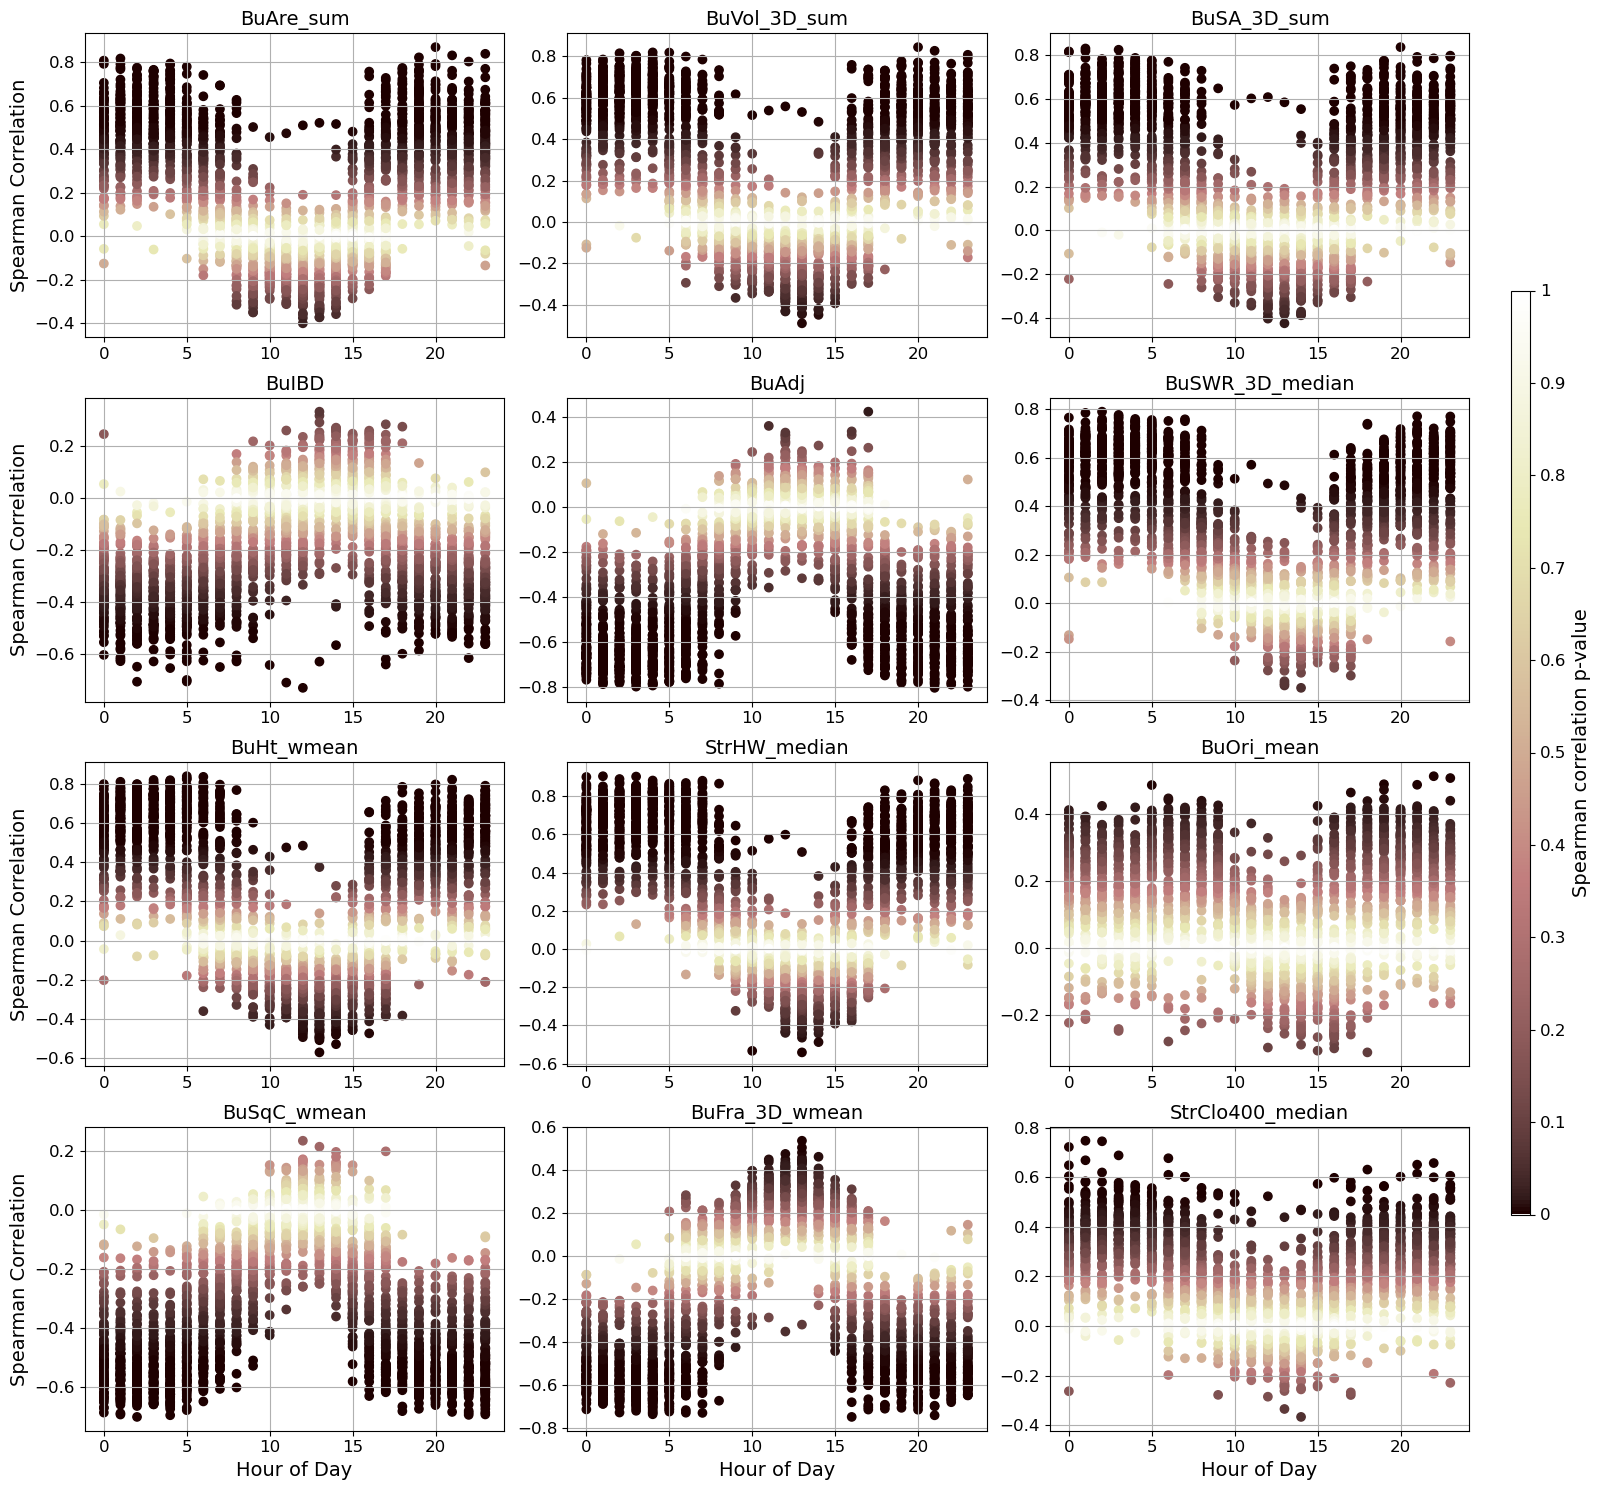

In [283]:
plot_diurnal_pub(season='year', radius=200)

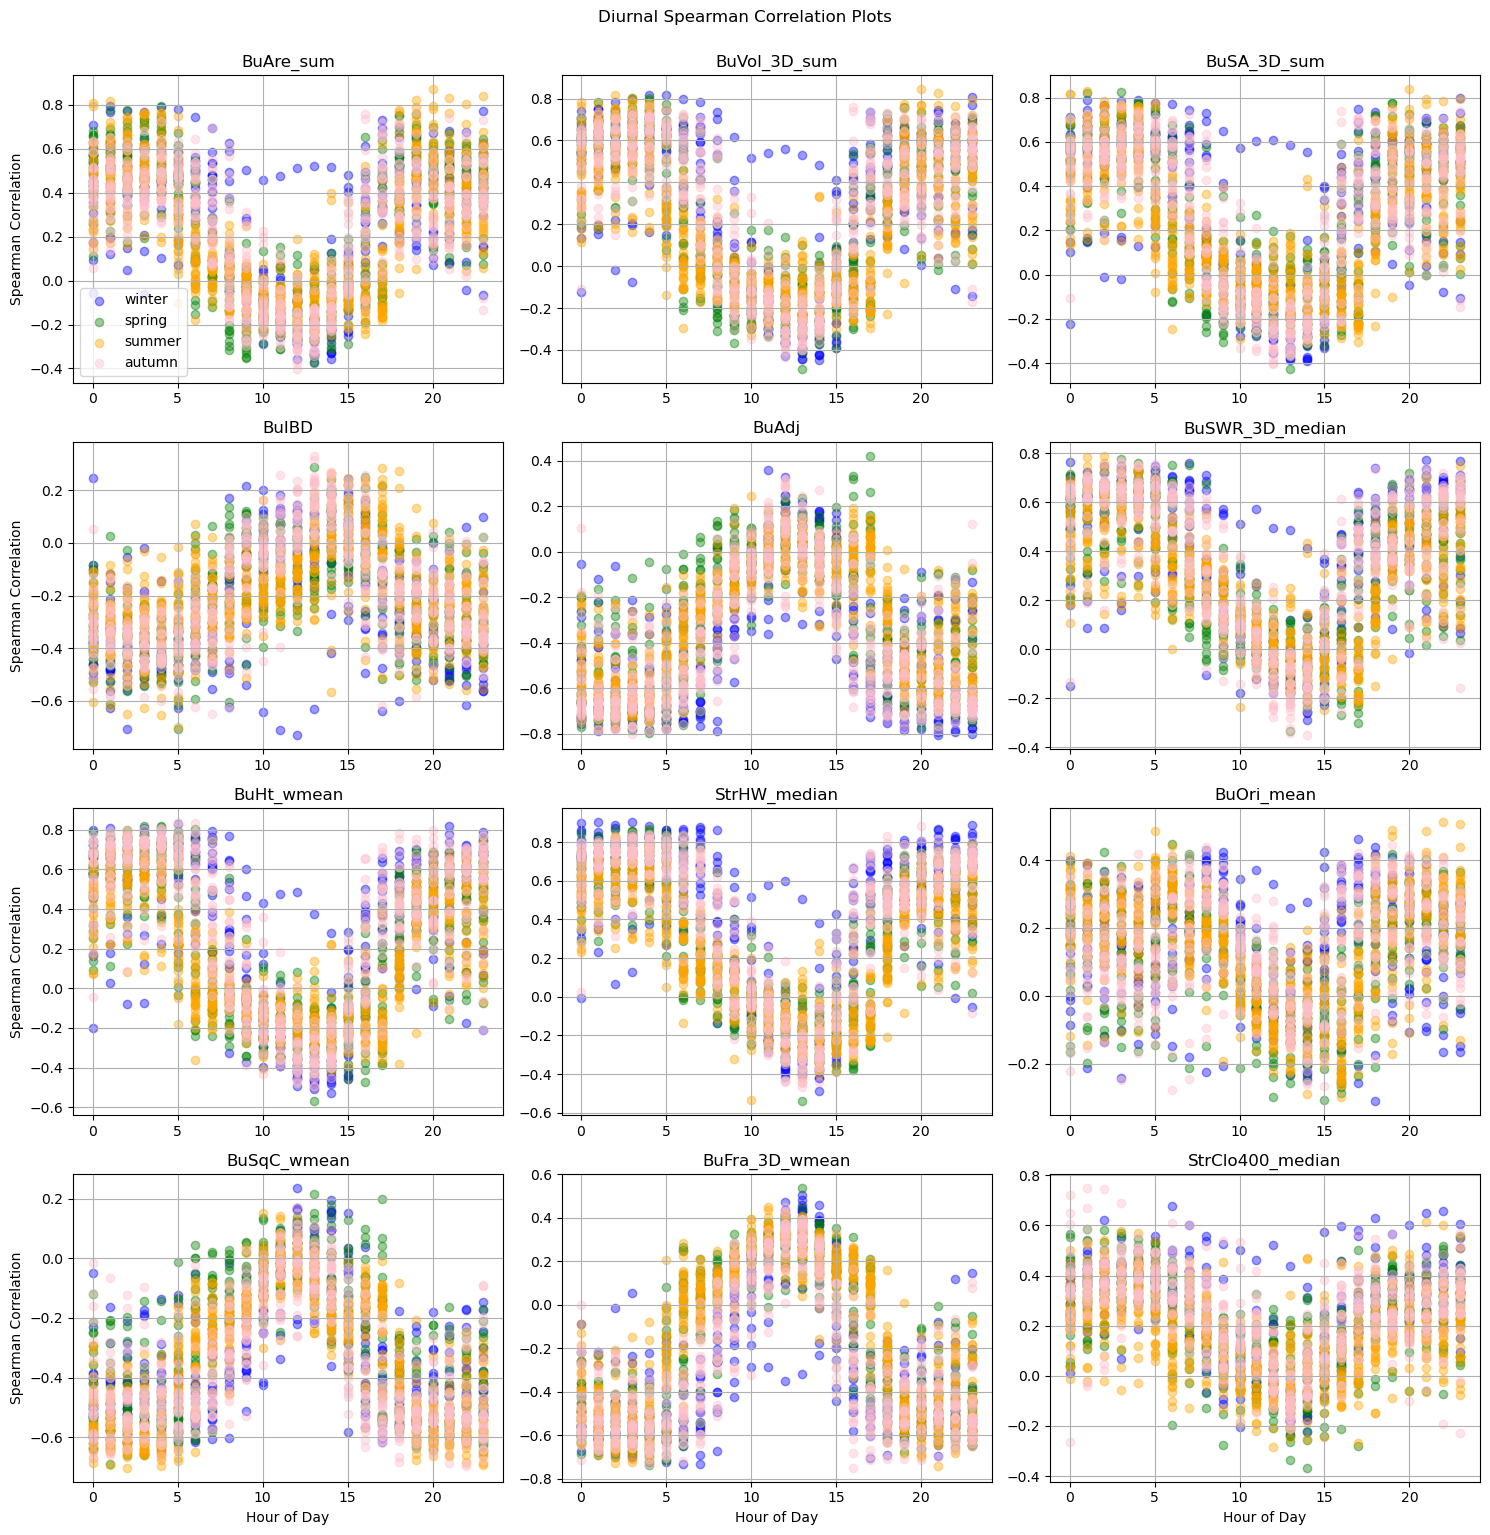

In [212]:
plot_diurnal_pub(season='year', radius=200)

In [214]:
plot_diurnal(season='year', radius=200)

In [184]:
plot_diurnal_p(season='year', radius=200)

## Summer

In [130]:
hid = pd.read_csv('/Users/lisawink/Documents/paper1/data/processed_data/heat_island_dates.csv')
hid['datetime_UTC']=pd.to_datetime(hid['datetime_UTC'])

In [131]:
hid = hid[hid['datetime_UTC'].dt.month.isin([6,7,8,9])]

In [133]:
i = 200

In [137]:
calc_diurnal(hid, radius=200, season='summer')

In [185]:
plot_diurnal(season='summer', radius=200)

In [186]:
plot_diurnal_p(season='summer', radius=200)

## Winter

In [147]:
hid = hid[hid['datetime_UTC'].dt.month.isin([11,12,1,2])]

In [151]:
calc_diurnal(hid, radius=50, season='winter')

In [187]:
plot_diurnal(season='winter', radius=200)

In [188]:
plot_diurnal_p(season='winter', radius=200)

### Radius 50

In [189]:
plot_diurnal(season='winter', radius=50)

In [190]:
plot_diurnal_p(season='winter', radius=50)

### Old

In [2]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# List of variables to plot
vars_to_plot = ["BuAre_sum", "BuHt_wmean", "BuVol_3D_sum", "StrHW_median", "BuAdj", "BuIBD", "BuFra_3D_median", "BuSqC_wmedian", "BuSWR_median"]
i=200

# Create a 3x3 subplot figure
fig = make_subplots(rows=3, cols=3, subplot_titles=vars_to_plot)

# Loop through variables and plot them in subplots
for idx, var in enumerate(vars_to_plot):
    row = idx // 3 + 1  # Determine row index (1-based)
    col = idx % 3 + 1    # Determine column index (1-based)
    
    # Load and process data
    stats_dict = pd.read_csv(f'/Users/lisawink/Documents/paper1/data/processed_data/diurnal/{var,i}.csv') 
    stats_dict['Time'] = pd.to_datetime(stats_dict['Time'])  # Ensure 'Time' is datetime
    stats_dict['Hour'] = stats_dict['Time'].dt.hour  # Extract hour

    # Create scatter plot
    scatter = go.Scatter(x=stats_dict['Hour'], y=stats_dict['Spearman Correlation'], 
                         mode='markers', name=var)

    # Add to subplot
    fig.add_trace(scatter, row=row, col=col)

# Update layout
fig.update_layout(title="Diurnal Spearman Correlation Plots", height=900, width=900, showlegend=False)

# Show figure
fig.show()

In [1]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# List of variables to plot
vars_to_plot = ["BuAre_sum", "BuHt_wmean", "BuVol_3D_sum", "StrHW_median", "BuAdj", "BuIBD", "BuFra_3D_median", "BuSqC_wmedian", "BuSWR_median"]
i=200

# Create a 3x3 subplot figure
fig = make_subplots(rows=3, cols=3, subplot_titles=vars_to_plot)

# Loop through variables and plot them in subplots
for idx, var in enumerate(vars_to_plot):
    row = idx // 3 + 1  # Determine row index (1-based)
    col = idx % 3 + 1    # Determine column index (1-based)
    
    # Load and process data
    stats_dict = pd.read_csv(f'/Users/lisawink/Documents/paper1/data/processed_data/diurnal/{var,i}.csv') 
    stats_dict['Time'] = pd.to_datetime(stats_dict['Time'])  # Ensure 'Time' is datetime
    stats_dict['Hour'] = stats_dict['Time'].dt.hour  # Extract hour

    # Create scatter plot
    scatter = go.Scatter(x=stats_dict['Hour'], y=stats_dict['Spearman p-value'], 
                         mode='markers', name=var)

    # Add to subplot
    fig.add_trace(scatter, row=row, col=col)

# Update layout
fig.update_layout(title="Diurnal Spearman Correlation p-value Plots", height=900, width=900, showlegend=False)

# Show figure
fig.show()